<h1> Manual Feature Extraction with Tsfresh </h1>

<h2> 1. Load data </h2>

In [11]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from scipy.signal import decimate
from tsfresh import extract_features
from tsfresh.feature_selection import select_features

In [ ]:
class DataProcessor:
    def __init__(self, input_path, file_names):
        self.input_path = input_path
        self.file_names = file_names
        
    def read_files(self):
        self.data = {}
        print("Reading files...")
        for file in self.file_names:
            with open(self.input_path + file + '.txt', 'r') as f:
                self.data[file] = pd.read_csv(f, header=None, sep='\t')
        return self.data
    
    def print_shape(self):
        print("Files read:")
        for file in self.data:
            print(f"{file}: {self.data[file].shape}")
            
    def create_target_df(self):
        target_columns = ['Cooler_Condition', 'Valve_Condition', 
                        'Internal_Pump_Leakage', 'Hydraulic_Accumulator', 
                        'Stable_Flag']
        self.data['target'].columns = target_columns
        self.valve_condition = self.data['target']['Valve_Condition']
        #del self.data['target']
        return self.valve_condition

def process_data():
    input_path = "input_data/"
    file_names = [
        "ce", "cp", "eps1", "se", "vs1", 
        "fs1", "fs2", 
        "ps1", "ps2", "ps3", "ps4", "ps5", "ps6",
        "ts1", "ts2", "ts3", "ts4", "target"
    ]
    
    processor = DataProcessor(input_path, file_names)
    data = processor.read_files()
    processor.print_shape()
    df_target = processor.create_target_df()
    df_target = processor.valve_condition
    return data, df_target

data, df_target = process_data()

<h2> 2. Signal Preprocessing </h2>

<h3> Input data </h3>

Steps:

<ul>
    <li>If the signal frequency is > 1 Hz, the signal gets downsampled to 1 Hz </li>
    <li>Downsampled signals are stored in a new dictionary</li>
    <li>An ID column gets added to the downsampled signals</li>
    <li>The downsampled signals are concatenated in one dataframe</li>
</ul>

In [ ]:
df_list = ['se', 'fs1', 'ps3']

df_downsampled = {}

for df in df_list:
    filtered_signals = []  # Reset for each DataFrame
    if data[df].shape[1] == 6000:
        downsample_factor = 100
        for i in range(data[df].shape[0]):
            row = data[df].iloc[i].values  # Extract row as a 1D array
            filtered_signal = decimate(row, downsample_factor, ftype='fir')  # Downsample
            filtered_signals.append(filtered_signal)  # Store the result
        # Create a new DataFrame with the filtered signals and add the 'id' column
        df_downsampled[df] = pd.DataFrame(filtered_signals)
        df_downsampled[df]["id"] = df_downsampled[df].index

    elif data[df].shape[1] == 600:
        downsample_factor = 10
        for i in range(data[df].shape[0]):
            row = data[df].iloc[i].values  # Extract row as a 1D array
            filtered_signal = decimate(row, downsample_factor, ftype='fir')  # Downsample
            filtered_signals.append(filtered_signal)  # Store the result
        # Create a new DataFrame with the filtered signals and add the 'id' column
        df_downsampled[df] = pd.DataFrame(filtered_signals)
        df_downsampled[df]["id"] = df_downsampled[df].index

    else:
        df_downsampled[df] = data[df]
        df_downsampled[df]["id"] = df_downsampled[df].index

# Combine all DataFrames
df_combined = pd.concat([df_downsampled[df] for df in df_list], ignore_index=True)

df_combined


<h3> Transform Input Data into long format </h3>

Since Tsfresh needs the input data in the long format, we transform our input DataFrame

In [25]:
df_combined_long = pd.melt(df_combined, id_vars=['id'], var_name='time', value_name='value')

<h3>Target Data</h3>

Steps:

<li>Encode Target labels</li>

In [26]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df_target)

<h2>3. Extract Features </h2>

In [ ]:
features = extract_features(df_combined_long, column_id="id", column_sort="time")   

In [28]:
# clean the features
features = features.dropna(axis=1)

features.replace([np.inf, -np.inf], np.nan, inplace=True)
features = features.dropna(how = "all", axis= "columns")

# Feature-Selektion basierend auf Zielwerten
features = select_features(features, y=y_encoded)

selector = VarianceThreshold()
features = selector.fit_transform(features)

In [ ]:
# check shape of feature and target
if features.shape[0] == y_encoded.shape[0]:
    print("Data is ready for Modelling!")
    print(f"Shape features: {features.shape}")
    print(f"Shape target: {y_encoded.shape}")
else:
    print("Shape of the Inputs and target don't match. Please check preprocesing steps")

<h2>4. Making predictions </h2>

In [30]:
states = [27, 6728, 49122]
accs = []
features = features
target = y_encoded

<h3>4.1. AdaBoost Classifier </h3>

In [ ]:
for RANDOM_STATE in states:
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size = 0.2, random_state = RANDOM_STATE, stratify = target
    )
    
    model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2),
    n_estimators=30
    )
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accs.append(accuracy_score(y_test, preds))
    print(f"Random State: {RANDOM_STATE}")
    print(classification_report(y_test, preds, zero_division=0.0))

accs_mean = round(np.mean(accs), 4)
accs_std = round(np.std(accs), 4)

print(f"Mean Accuracy: {accs_mean}")
print(f"Std Accuracy: {accs_std}")

<h3> 4.2. Support Vector Machines </h3>

In [ ]:
for RANDOM_STATE in states:
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size = 0.2, random_state = RANDOM_STATE, stratify = target
    )
    
    clf = svm.SVC(kernel='linear')
    
    clf.fit(X_train, y_train)
    preds = model.predict(X_test)
    accs.append(accuracy_score(y_test, preds))
    print(f"Random State: {RANDOM_STATE}")
    print(classification_report(y_test, preds, zero_division=0.0))

accs_mean = round(np.mean(accs), 4)
accs_std = round(np.std(accs), 4)

print(f"Mean Accuracy: {accs_mean}")
print(f"Std Accuracy: {accs_std}")

<h3>4.3. K-Nearest Neighbours</h3>

In [ ]:
for RANDOM_STATE in states:
 
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=RANDOM_STATE, stratify=target
    )
    
    # Standardise features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    
    preds = knn.predict(X_test)  # Korrigiert von `model.predict` zu `knn.predict`
    accs.append(accuracy_score(y_test, preds))
    
    # Ergebnisse ausgeben
    print(f"Random State: {RANDOM_STATE}")
    print(classification_report(y_test, preds, zero_division=0.0))


accs_mean = round(np.mean(accs), 4)
accs_std = round(np.std(accs), 4)

print(f"Mean Accuracy: {accs_mean}")
print(f"Std Accuracy: {accs_std}")

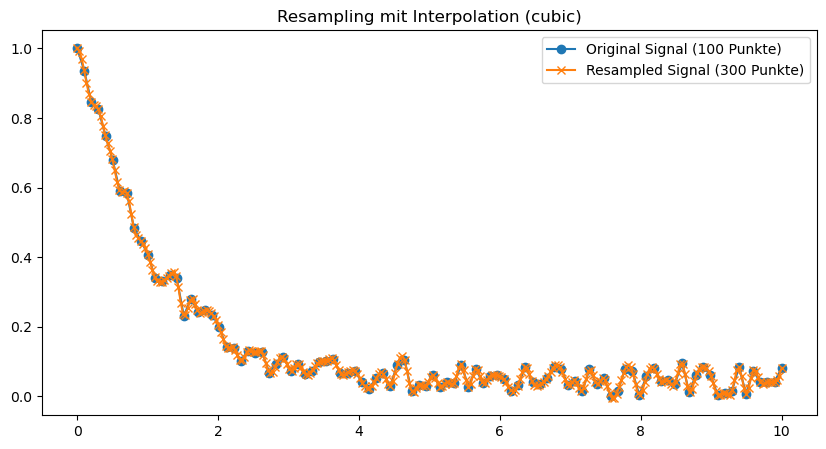

In [34]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

# Nicht-periodisches Signal erstellen
x = np.linspace(0, 10, 100)  # Ursprüngliche Zeitpunkte
y = np.exp(-x) + np.random.rand(100) * 0.1

# Ziel-Zeitpunkte
x_new = np.linspace(0, 10, 300)

# Interpolation
interpolator = interp1d(x, y, kind='cubic')  # Kubische Interpolation
y_resampled = interpolator(x_new)

# Visualisierung
plt.figure(figsize=(10, 5))
plt.plot(x, y, 'o-', label='Original Signal (100 Punkte)')
plt.plot(x_new, y_resampled, 'x-', label='Resampled Signal (300 Punkte)')
plt.legend()
plt.title('Resampling mit Interpolation (cubic)')
plt.show()
